1. Propiedades:

NGC 121 es un cúmulo globular perteneciente a la pequeña nube de magallanes. 
Tiene una magnitud aparente de 11.24 y un radio de 54 pc. 
Sus coordenadas son RA: 00h26m48.25s, DEC: -71d32m08.4s.
Su modulo de distancia (m-M)=18.94 y su distancia es de 0.061Mpc.

Todos estos datos fueron obtenidos de los catalogos de Simbad y NED (https://goo.gl/q5GuSw).

2.ACS (Advanced Camera for Surveys) es un instrumento del telescopio espacial Hubble capaz de observar entre UV y near-IR. HRC (High-Resolution Camera) es una de las 3 cámaras del instrumento.

Los filtros F555W y F814W son de longitudes 5400 y 8000 Angstrom. Sus equivalente mas cercanos en el sistema de Johnson son V (5510A) y I (8060A) respectivamente.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.io import fits

f5 = fits.open('hst_10396_a4_acs_hrc_f555w_drz.fits')
f8 = fits.open('hst_10396_a4_acs_hrc_f814w_drz.fits')

Según la documentación de sitio Hubble Legacy Archives el segundo .fit pertenece a los pesos (inversos de la varianza). Luego será este el que se le entrega a SExtractor. 

Importante que los fits extraidos mantengan sus headers, ya que SExtractor usará estos luego para extraer las coordenadas de NGC 121 y así usando la escala pixel-arcsec darle una ubicación espacial real a cada estrella.

In [ ]:
var = f5[2]
var.writeto('innvar_f555w_N121.fits',clobber=True)
var = f8[2]
var.writeto('innvar_f814w_N121.fits',clobber=True)

Ahora lo mismo pero con la imagen de ciencia (primera extension):

In [ ]:
sci = f5[1]
sci.writeto('sci_f555w_N121.fits',clobber=True)
sci = f8[1]
sci.writeto('sci_f814w_N121.fits',clobber=True)

Comparando las imagenes lado a lado se ve que estan alineadas, analizando estrellas en particular en cada filtro se ve que tienen la misma posición.

In [ ]:
%matplotlib inline

imgf555=fits.open("sci_f555w_N121.fits")
imgf814=fits.open("sci_f814w_N121.fits")
imgf5=imgf555[1].data
imgf8=imgf814[1].data
plt.imshow(np.log10(imgf5))


In [ ]:
plt.imshow(np.log10(imgf8))

3
Esta sección depende de los parametros de input (config.txt) y output (archivo .param) que estan explicados al final del notebook.

Para medir fotometria de apertura de 6 pixeles se debe cambiar la opción de fotometría automática del archivo de outputs por la de fotometría de apertura, luego debemos dar los 6 pixeles de diametro en el input.

Respecto a las coordenadas, SExtractor reconoce las coordenadas directamente del header que acompaña a cada imagen, por lo que es importante al extraer las extensiones que estas mantengan sus headers respectivos. Luego usando la conversion pixel a ángulo dada en el header (tomada automaticamente) se encuentran las coordenadas de los centroides de cada fuente, esto último se debe especificar en el archivo de output.

Las varianzas inversas obtenidas anteriormente se utilizan como pesos. El archivo de configuración y parametros de output estan incluidos junto a este notebook con los nombres config.txt y config.param respectivamente.

Si quiere correr SExtractor en su propio computador lo debe hacer desde las carpetas f555w y f814w que corresponden a las imagenes del mismo filtro.

4.Formando 4 listas que contengan las RA y DEC de los cuerpos de ambos filtros para despues hacer un match, se encuentran cuales estrellas de F555W corresponden a cuales de F814W, también se obtiene la distancia angular entre los cuerpos que se consideraron como un match.


In [1]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import ascii

f5=ascii.read("f5.txt")
f8=ascii.read("f8.txt")

ra5=[]
dec5=[]
ra8=[]
dec8=[]

for i in f5:
    ra5.append(i[5])
    dec5.append(i[6])
for i in f8:
    ra8.append(i[5])
    dec8.append(i[6])
    

c1 = SkyCoord(ra=ra5*u.degree, dec=dec5*u.degree)#f555w
c2 = SkyCoord(ra=ra8*u.degree, dec=dec8*u.degree) #f814w
match, dist, d3d = c2.match_to_catalog_sky(c1,nthneighbor=1) 

#for i in range(3090,3100):
#    print c1[match[i]],c2[i]
#    print dist[i]

Por ejemplo, se da un match entre estas dos estrellas de los distintos filtros, las cuales estan separadas por la distasncia entregada abajo.

   SkyCoord (ICRS): (ra, dec) in deg
    (6.6947746, -71.5404345) 
   SkyCoord (ICRS): (ra, dec) in deg
    (6.6947839, -71.5404374)  
    
    
    
Distancia angular: 0d00m00.0149s

El siguiente paso consiste en obtener las magnitudes para ambos filtros de cada estrella y generar una CMD a partir de ellas. Para esto es que se llevo a cabo el "match" anterior. 

Entonces, extrayendo las magnitudes de los catalogos de sextractor que generamos (f5.txt y f8.txt):


Los reddening se obtienen del sitio sitado en la primera pregunta (NED - NGC121).

Las correciones de apertura estan dadas en las tablas de Bohlin et al 2015 (http://www.stsci.edu/hst/acs/analysis/apcorr)

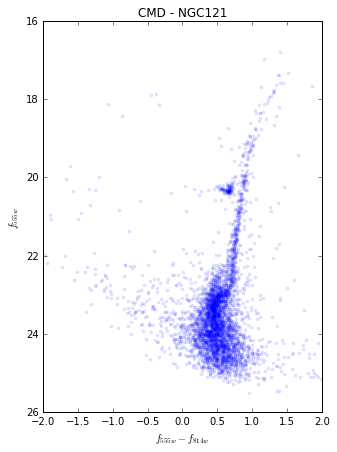

In [7]:

mag5=[]
mag8=[]
mag5inicial=[]

for i in f5:
    mag5inicial.append(i[3])
for i in f8:
    mag8.append(i[3]+24.849+0.056) #Agregamos zero point y reddening
for i in match:
    mag5.append(mag5inicial[i]+25.255+0.103) #Agregamos zero point y reddening


#mag8 tiene las magnitudes de f814w
#mag5 tiene las magnitudes de f555w

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.figure(figsize=(5,7))
ax = plt.gca()
ax.invert_yaxis()
plt.xlim(-2,2)
plt.title("CMD - NGC121")
plt.xlabel("$f_{555w}-f_{814w}$")
plt.ylabel("$f_{555w}$")
plt.plot(np.array(mag5) -np.array(mag8),np.array(mag5),".",color="blue",alpha = 0.1)
    
    
    

Sobre los parametros de input:
    
    DETECT_MINAREA   6
    
La cantidad de pixeles que deben estar sobre el threshold para que un cuerpo se considere como estrella. 
Un número muy bajo hará que se detecten las estrellas más leves pero al mismo tiempo se considerará ruido como estrellas.  
Un número muy alto hará que no se consideren como estrella cuerpos tenues que en realidad si lo son. 
    
    
    DETECT_THRESH    1.5 
Este será el threshold que concidera DETECT_MINAREA, cualquier pixel sobre este sigma será considerado, pero para este caso se necesitan 6 pixeles juntos o más para que SExtractor lo tome como una detección de estrella. 
Al asignar un sigma un poco mayor a 1 se asegura que habrán detecciones que sobresalgan del background y que al mismo tiempo no se ignoren señales más debiles (lo que sucedería con un valor >>1).
    
    
    
    WEIGHT_TYPE      MAP_WEIGHT                               
    WEIGHT_IMAGE     innvar_fxxxw_N121.fits (555 o 814)

Los pesos le darán una importancia relativa a cada uno de los pixeles. En este caso se utiliza MAP_WEIGHT ya que obtuvimos los inversos de las varianzas (pesos) directamente de la segunda extensión del .fits como vimos previamente
        
    
    PHOT_APERTURES   6
Como fue pedido el diametro de apertura es de 6 pixeles.
Importante notar que solo se usó con fotometría de apertura y no se debe usar la opción auto, ya que esta segunda asignará la elipse que SExtractor considere más apropiada para cada detección, con lo cual asignará elipses a grupos de estrellas entre otras cosas. PHOT_APERTURES solo trabaja con circulos y como los cuerpos estudiados son estrellas es esto lo que se quiere.
    
    MAG_ZEROPOINT    0
SExtractor permite asignar un zeropoint dentro del mismo input, este se dejo como 0 inicialmente y despues simplemente se agrego en el codigo, para el sistema Vega MAG:

ZPT F555w = 25.255

ZPT F814w = 24.849

Estos valores se obtienen de Sirianni et al 2005 y corresponden al sistema VEGAMAG, el cual esta definido por la magnitud de la estrella Vega en distintos filtros, es decir, $ M_{vega \lambda}+Zpt_{\lambda}=0 $.
   
    
    GAIN             1.0

Segun especifica el header las imagenes ya estarían en electrones, por lo que no se necesita transformar de ADU a electrón.
    
    GAIN_KEY         -  
Se deja esto para que SExtractor no busque el gain dentro del header (ya que este si esta dado, pero por lo anterior no es necesario). 
    
    PIXEL_SCALE      0 
Esta es la transformación de pixel a escala angular, lo cual permite darle una ubicación espacial en RA/DEC a cada estrella encontrada. Al darle un valor de 0 SExtractor busca este valor directamente en el header.    
        
    CHECKIMAGE_TYPE  APERTURES 
    CHECKIMAGE_NAME  AP_Fx.fits 

Es posible pedirle al programa que entregue una imagen con los cuerpos encontrados y las aperturas (APERTURES) que se les dio, util para entender que esta sucediendo realmente. Dando otros parametros se pueden recibir imagenes que indican otras cosas.
  
Si se quiere revisar este .fits, se creara con el nombre AP_f(5 o 8).fits luego de correr SExtractor.
  
  
  

Respecto al output:

    MAG_APER(1)
Indicamos que nos devuelva las magnitudes dadas por la fotometría de apertura (circular). 
    
    ALPHA_J2000
Devuelve las asenciones rectas de cada estrella, suponiendo que hayamos configurado bien PIXEL_SCALE.
    
    
    DELTA_J2000
Devuelve las declinaciones de cada estrella.


Entre otros outputs que resaltan estan, flujos, posiciones en pixeles, errores de flujo/magnitud y otros tipos de fotometría. Pero estos no son de suma importancia para obtener la CMD.
    

Respecto a las definiciones pedidas:

Reddening: Es el efecto causado por la extinción de luz debido al material presente entre la fuente y el observador. 
Como el polvo interestelar absorbe principalmente ondas de alta frecuencia las estrellas que sufren de extinción se ven más "rojizas" por el observador que lo que son realmente.

Zero-point: El zero-point usado en este trabajo (VegaMag) es un sistema definido por las magnitudes de vega, de tal modo que al sumarles este zero-point quedan en 0. También existe el zero-point instrumental, que indica la magnitud de una fuente que exitará un electrón por segundo de la CCD.